<a href="https://colab.research.google.com/github/cchang-vassar/Semantic-Relations-in-Vector-Embeddings/blob/main/study2_11_%5Bada003_arguana%5Ddiff_model_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ada-003] Autoencoder: Generate Corresponding Embedding

Try 2 new architectures:


1.   2 hidden layers: 1536*2 -> 1536
2.   3 hidden layers: 1536\*4 -> 1536\*2 -> 1536



## Set Up

### Imports

In [ ]:
!pip install tensorflow

In [44]:
import os
import subprocess
import zipfile
import shutil
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import userdata
from scipy import spatial
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from plotnine import ggplot, geom_line, aes, ggsave, labs, theme, element_text, guides, guide_legend, scale_color_manual, scale_linetype_manual

### OSF Setup

In [ ]:
!pip install osfclient

In [ ]:
import osfclient.cli

In [ ]:
from osfclient.api import OSF
from osfclient.models import Project, Storage
from io import BytesIO

In [ ]:
os.environ["OSF_USERNAME"] = userdata.get("OSF_USERNAME")
OSF_USERNAME = os.environ["OSF_USERNAME"]

In [ ]:
os.environ["OSF_PASSWORD"] = userdata.get("OSF_PASSWORD")
OSF_PASSWORD = os.environ["OSF_PASSWORD"]

In [ ]:
os.environ["OSF_TOKEN"] = userdata.get("OSF_TOKEN")
OSF_TOKEN = os.environ["OSF_TOKEN"]

In [ ]:
os.environ["OSF_PROJECT_ID"] = userdata.get("OSF_PROJECT_ID")
OSF_PROJECT_ID = os.environ["OSF_PROJECT_ID"]

## Data

### Import training data from OSF

In [ ]:
!osf -p sakjg fetch osfstorage/data-dump/ada003-autoencoder/ada_autoencoder.zip

100% 256M/256M [00:14<00:00, 18.2Mbytes/s]


In [ ]:
!osf -p sakjg fetch osfstorage/data-dump/ada003-autoencoder/ada_embeddings_dump.zip

100% 71.9M/71.9M [00:04<00:00, 15.5Mbytes/s]


In [ ]:
ada_autoencoder_file_path = 'ada_autoencoder.zip'
output_folder_path = 'current-data-dump/ada-autoencoder'
os.makedirs(output_folder_path, exist_ok=True)

with zipfile.ZipFile(ada_autoencoder_file_path, 'r') as zip_ref:
  zip_ref.extractall(output_folder_path)

extracted_files = os.listdir(output_folder_path)
print("Files extracted:", extracted_files)

Files extracted: ['global_training_plot.png', 'x_test.pkl', 'y_test.pkl', 'y_teset.pkl', 'global_shuffled_training_plot.png', 'global_shuffled_training_log.csv', 'training_df.pkl', 'combined_global_training_plot.png', 'global_training_df.pkl', 'global_shuffled_autoencoder_model.keras', 'x_train.pkl', 'y_train.pkl', 'global_autoencoder_model.keras', 'global_training_log.csv']


In [ ]:
ada_embeddings_file_path = 'ada_embeddings_dump.zip'
output_folder_path = 'current-data-dump/embeddings-dump'
os.makedirs(output_folder_path, exist_ok=True)

with zipfile.ZipFile(ada_embeddings_file_path, 'r') as zip_ref:
  zip_ref.extractall(output_folder_path)

extracted_files = os.listdir(output_folder_path)
print("Files extracted:", extracted_files)

Files extracted: ['economy', 'test', 'training', '.ipynb_checkpoints']


In [ ]:
x_train = pd.read_pickle('current-data-dump/ada-autoencoder/x_train.pkl')
y_train = pd.read_pickle('current-data-dump/ada-autoencoder/y_train.pkl')
x_test = pd.read_pickle('current-data-dump/ada-autoencoder/x_test.pkl')
y_test = pd.read_pickle('current-data-dump/ada-autoencoder/y_test.pkl')

## Metric

In [ ]:
@tf.keras.saving.register_keras_serializable()
def metric_choose_argument_global_y_train(y_true, y_pred):
  """global_metric"""
  global_training_df_32 = tf.cast(pd.concat([x_train, y_train, x_test, y_test]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(global_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(global_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(global_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(global_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

## 2-layer model

### 2-layer architecture

In [ ]:
# Layers
input_layer = tf.keras.layers.Input(shape=(1536, ), name="Input")
hidden_layer_1 = tf.keras.layers.Dense(units=1536*2, activation="relu", name="Hidden1")(input_layer)
hidden_layer_2 = tf.keras.layers.Dense(units=1536, activation="relu", name="Hidden2")(hidden_layer_1)
output_layer = tf.keras.layers.Dense(units=1536, activation="linear", name="Output")(hidden_layer_2)

In [ ]:
# Model
autoencoder_model_2_layer = tf.keras.Model(inputs=input_layer, outputs=output_layer)
autoencoder_model_2_layer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1536)]            0         
                                                                 
 Hidden1 (Dense)             (None, 3072)              4721664   
                                                                 
 Hidden2 (Dense)             (None, 1536)              4720128   
                                                                 
 Output (Dense)              (None, 1536)              2360832   
                                                                 
Total params: 11802624 (45.02 MB)
Trainable params: 11802624 (45.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Global Training

In [ ]:
# Global Model
global_autoencoder_model_2_layer = autoencoder_model_2_layer
global_autoencoder_model_2_layer.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_y_train]
)

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='global_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='global_training_log.csv', separator=',', append=True)
global_history_2_layer = global_autoencoder_model_2_layer.fit(
  x=x_train,
  y=y_train,
  batch_size=1,
  epochs=50,
  validation_data = (x_test, y_test),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/50
4064/4065 [============================>.] - ETA: 0s - loss: -0.6004 - metric_choose_argument_global_y_train: 0.0261
Epoch 1: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 57s 11ms/step - loss: -0.6005 - metric_choose_argument_global_y_train: 0.0261 - val_loss: -0.6391 - val_metric_choose_argument_global_y_train: 0.0557
Epoch 2/50
4064/4065 [============================>.] - ETA: 0s - loss: -0.6974 - metric_choose_argument_global_y_train: 0.1026
Epoch 2: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 37s 9ms/step - loss: -0.6974 - metric_choose_argument_global_y_train: 0.1026 - val_loss: -0.6719 - val_metric_choose_argument_global_y_train: 0.0871
Epoch 3/50
4064/4065 [============================>.] - ETA: 0s - loss: -0.7423 - metric_choose_argument_global_y_train: 0.2197
Epoch 3: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 34s 8ms/

In [ ]:
global_history_df_2_layer = pd.DataFrame(global_history_2_layer.history)

In [ ]:
output_folder_path = 'current-data-dump/ada-autoencoder/other-architectures/2-layer-architecture/'
os.makedirs(output_folder_path, exist_ok=True)
global_history_df_2_layer.to_csv(f'{output_folder_path}global_training_log.csv')
global_autoencoder_model_2_layer.save(f'{output_folder_path}global_autoencoder_model.keras')

## 3-layer model

### 3-layer architecture

In [ ]:
# Layers
input_layer = tf.keras.layers.Input(shape=(1536, ), name="Input")
hidden_layer_1 = tf.keras.layers.Dense(units=1536*4, activation="relu", name="Hidden1")(input_layer)
hidden_layer_2 = tf.keras.layers.Dense(units=1536*2, activation="relu", name="Hidden2")(hidden_layer_1)
hidden_layer_3 = tf.keras.layers.Dense(units=1536, activation="relu", name="Hidden3")(hidden_layer_2)
output_layer = tf.keras.layers.Dense(units=1536, activation="linear", name="Output")(hidden_layer_3)

In [ ]:
# Model
autoencoder_model_3_layer = tf.keras.Model(inputs=input_layer, outputs=output_layer)
autoencoder_model_3_layer.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1536)]            0         
                                                                 
 Hidden1 (Dense)             (None, 6144)              9443328   
                                                                 
 Hidden2 (Dense)             (None, 3072)              18877440  
                                                                 
 Hidden3 (Dense)             (None, 1536)              4720128   
                                                                 
 Output (Dense)              (None, 1536)              2360832   
                                                                 
Total params: 35401728 (135.05 MB)
Trainable params: 35401728 (135.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Global Training

In [ ]:
# Global Model
global_autoencoder_model_3_layer = autoencoder_model_3_layer
global_autoencoder_model_3_layer.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_y_train]
)

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='global_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='global_training_log.csv', separator=',', append=True)
global_history_3_layer = global_autoencoder_model_3_layer.fit(
  x=x_train,
  y=y_train,
  batch_size=1,
  epochs=50,
  validation_data = (x_test, y_test),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/50
4062/4065 [============================>.] - ETA: 0s - loss: -0.5330 - metric_choose_argument_global_y_train: 0.0044
Epoch 1: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 97s 21ms/step - loss: -0.5329 - metric_choose_argument_global_y_train: 0.0044 - val_loss: -0.5746 - val_metric_choose_argument_global_y_train: 0.0064
Epoch 2/50
4063/4065 [============================>.] - ETA: 0s - loss: -0.6210 - metric_choose_argument_global_y_train: 0.0263
Epoch 2: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 73s 18ms/step - loss: -0.6210 - metric_choose_argument_global_y_train: 0.0263 - val_loss: -0.6155 - val_metric_choose_argument_global_y_train: 0.0250
Epoch 3/50
4065/4065 [==============================] - ETA: 0s - loss: -0.6705 - metric_choose_argument_global_y_train: 0.0635
Epoch 3: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 74s 18m

In [ ]:
global_history_df_3_layer = pd.DataFrame(global_history_3_layer.history)

In [ ]:
output_folder_path = 'current-data-dump/ada-autoencoder/other-architectures/3-layer-architecture/'
os.makedirs(output_folder_path, exist_ok=True)
global_history_df_3_layer.to_csv(f'{output_folder_path}global_training_log.csv')
global_autoencoder_model_3_layer.save(f'{output_folder_path}global_autoencoder_model.keras')

## Plot training history

### 1-layer architecture training history

In [41]:
# Access training history
global_history_1_layer = pd.DataFrame(pd.read_csv('current-data-dump/ada-autoencoder/global_training_log.csv'))
global_history_1_layer = pd.melt(global_history_1_layer, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], var_name='dataset', value_name='accuracy')
global_history_1_layer = global_history_1_layer.replace(['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], ['training set', 'validation set'])
global_history_1_layer.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
global_history_1_layer['layers'] = '1'

### 2-layer architecture training history

In [ ]:
# Access training history
global_history_2_layer = pd.DataFrame(pd.read_csv('current-data-dump/ada-autoencoder/other-architectures/2-layer-architecture/global_training_log.csv'))
global_history_2_layer = pd.melt(global_history_2_layer, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], var_name='dataset', value_name='accuracy')
global_history_2_layer = global_history_2_layer.replace(['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], ['training set', 'validation set'])
global_history_2_layer.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
global_history_2_layer['layers'] = '2'

In [ ]:
global_training_plot_2_layer = ggplot(global_history_2_layer, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Unshuffled Data', x='Epoch', y='Accuracy')
ggsave(global_training_plot_2_layer, "current-data-dump/ada-autoencoder/other-architectures/2-layer-architecture/global_training_plot.png")

### 3-layer architecture training history

In [ ]:
# Access training history
global_history_3_layer = pd.DataFrame(pd.read_csv("current-data-dump/ada-autoencoder/other-architectures/3-layer-architecture/global_training_log.csv"))
global_history_3_layer = pd.melt(global_history_3_layer, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], var_name='dataset', value_name='accuracy')
global_history_3_layer = global_history_3_layer.replace(['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], ['training set', 'validation set'])
global_history_3_layer.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
global_history_3_layer['layers'] = '3'

In [ ]:
global_training_plot_3_layer = ggplot(global_history_3_layer, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Shuffled Data', x='Epoch', y='Accuracy')
ggsave(global_training_plot_3_layer, "current-data-dump/ada-autoencoder/other-architectures/3-layer-architecture/global_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada-autoencoder/other-architectures/3-layer-architecture/global_training_plot.png


## Combined Training Plots

In [42]:
combined_global_training_df = pd.concat([global_history_1_layer, global_history_2_layer, global_history_3_layer])

In [47]:
color_map = {'1': '#AAAAAA', '2': '#777777', '3': 'black'}
linetype_map={'validation set': 'solid', 'training set': 'dashed'}

combined_global_plot = (
  ggplot(combined_global_training_df, aes(x='epoch', y='accuracy', linetype='dataset', color='layers')) +
  geom_line(size=2) +
  labs(title='Learning Curves of 1-Layer vs 2-Layer vs 3-Layer Networks (ArguAna; ada003)', x='Epoch', y='Accuracy') +
  scale_color_manual(color_map) +
  scale_linetype_manual(linetype_map) +
  theme(
    figure_size=(16,24),
    axis_title=element_text(size=40),
    axis_text=element_text(size=32),
    legend_title=element_text(size=40, lineheight=1.5),
    legend_text=element_text(size=32, lineheight=1.5),
    plot_title=element_text(size=48, wrap=True, lineheight=1.5),
    legend_position="bottom",
    legend_key_width=64
  ) +
  guides(fill = guide_legend(byrow = True))
)
ggsave(combined_global_plot, "current-data-dump/ada-autoencoder/other-architectures/combined_global_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada-autoencoder/other-architectures/combined_global_training_plot.png


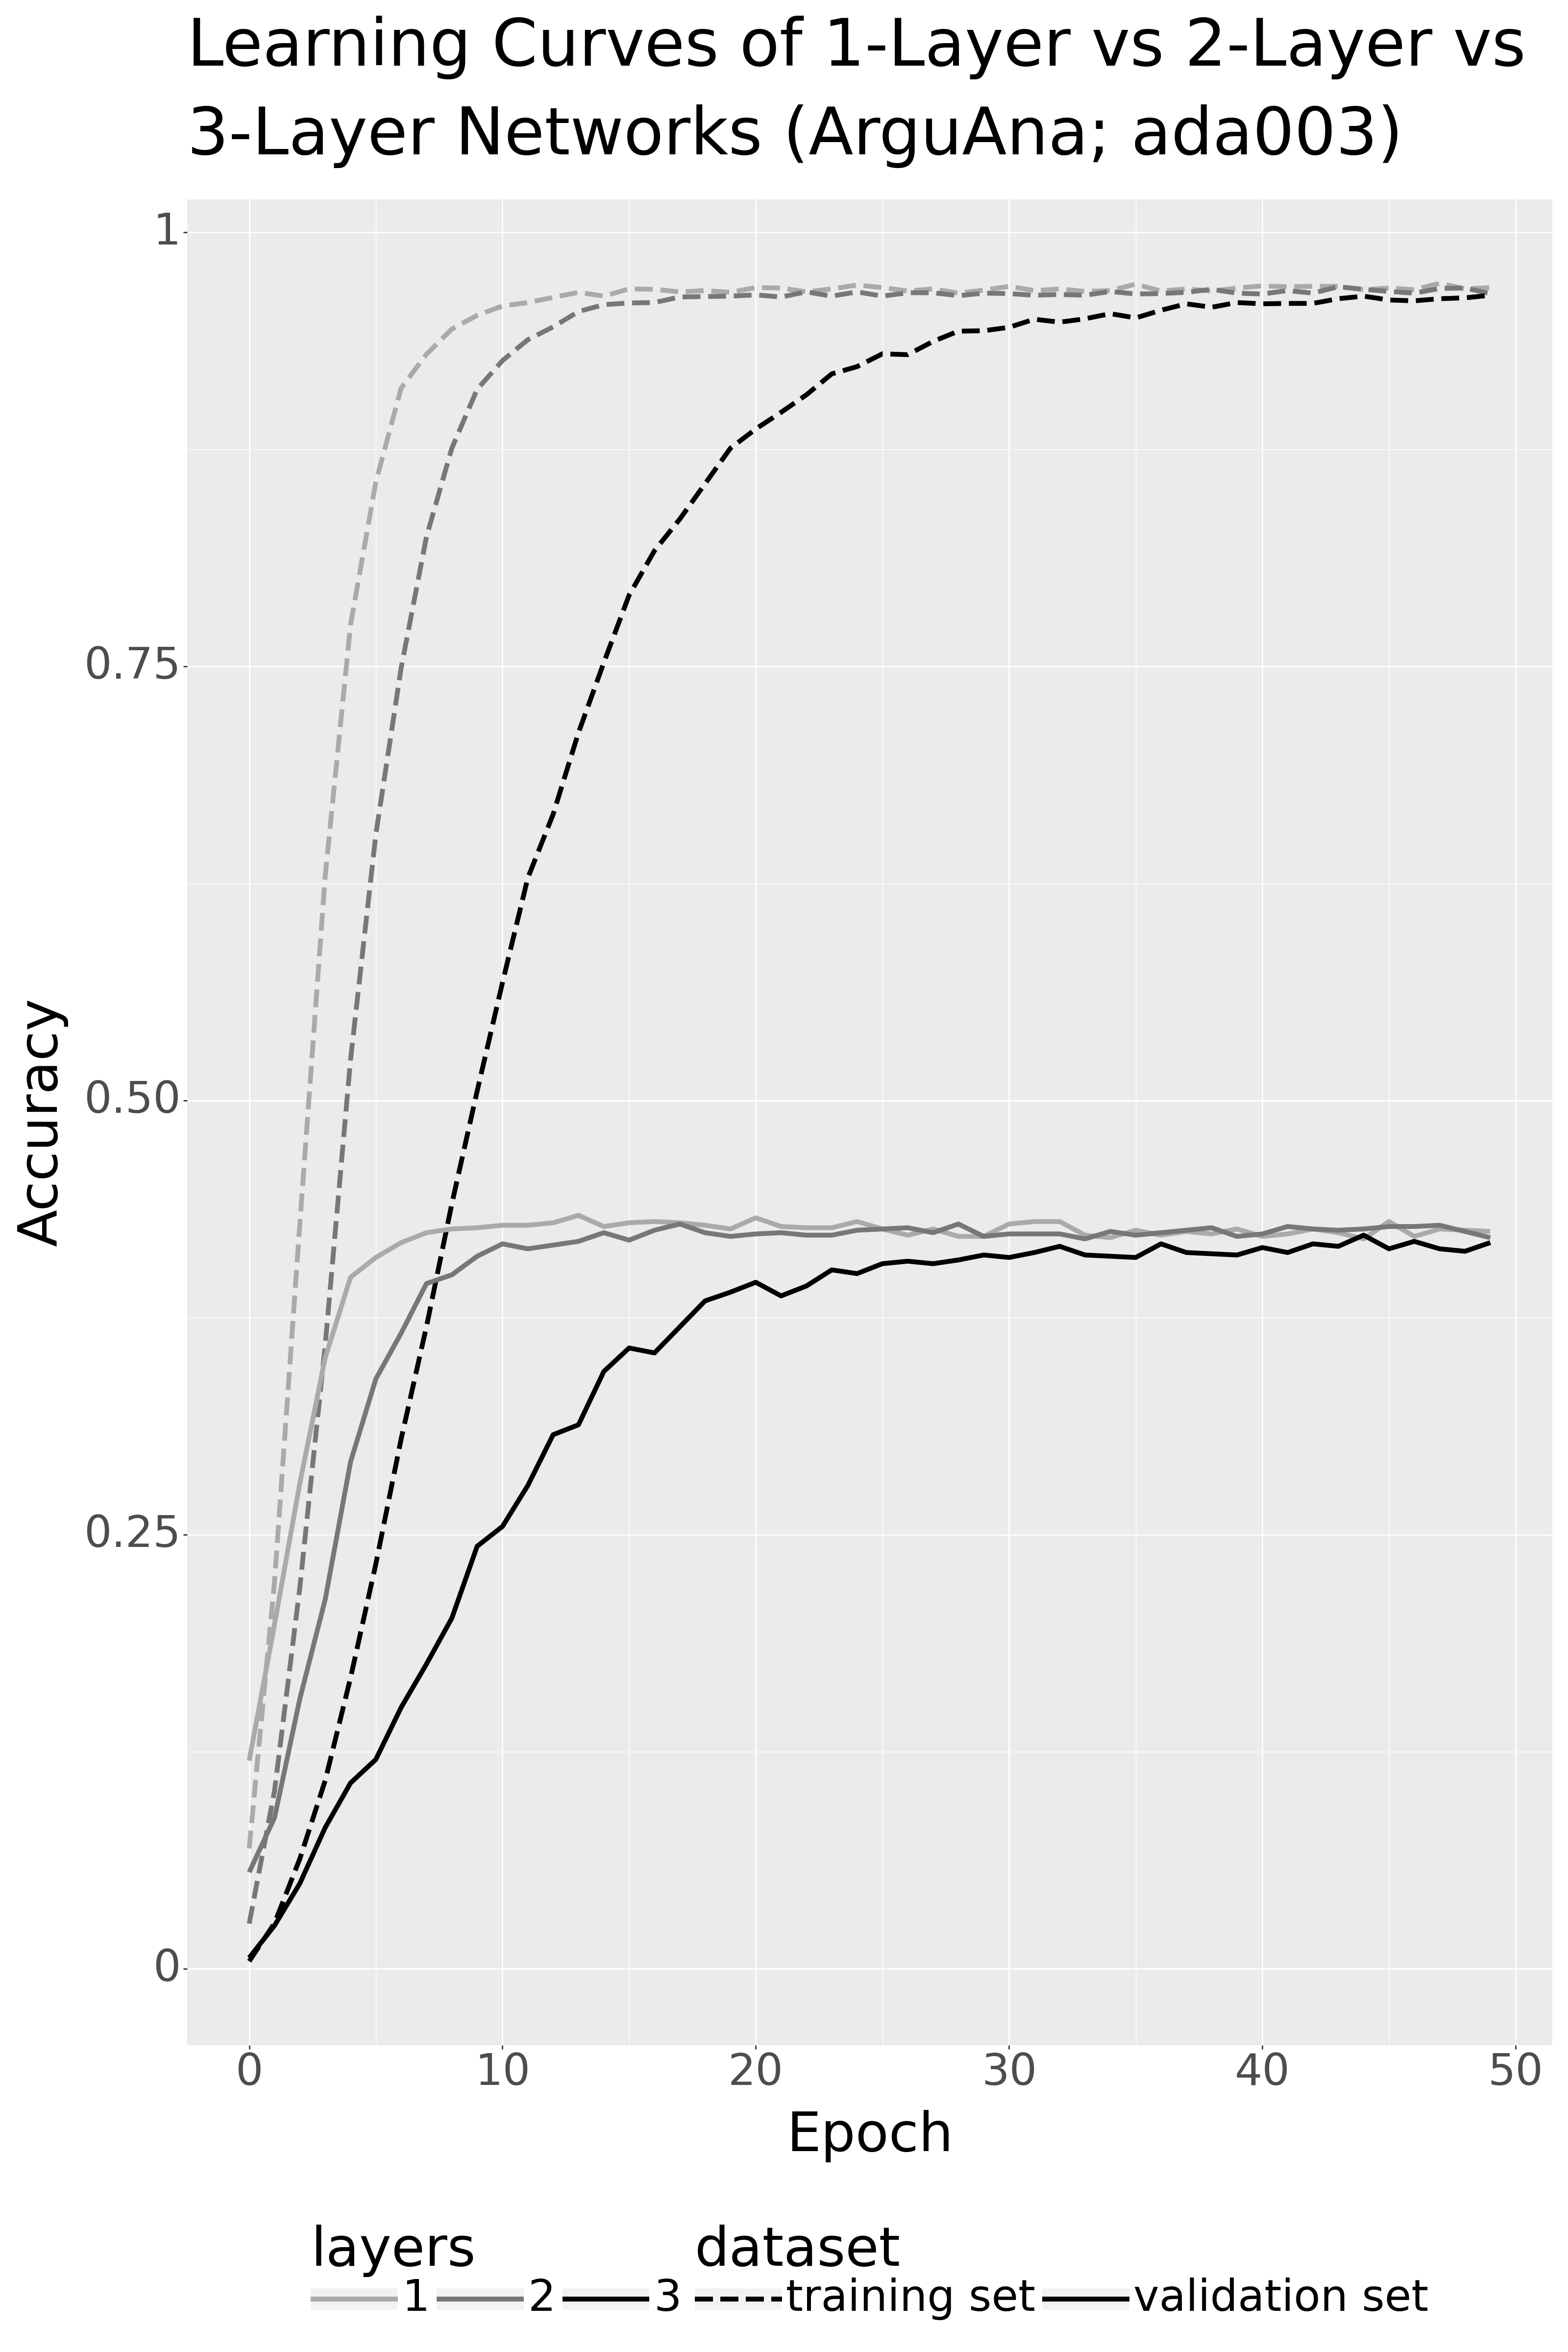

<Figure Size: (1600 x 2400)>

In [48]:
combined_global_plot

## Final Export

In [ ]:
other_architectures_file_path = 'current-data-dump/ada-autoencoder/other-architectures/'
other_architectures_file_path_zip = 'current-data-dump/ada-autoencoder/other-architectures/'
shutil.make_archive(other_architectures_file_path_zip, 'zip', other_architectures_file_path)
print(f"Zip file created at: {other_architectures_file_path_zip}")
result = subprocess.run([f"osf -p sakjg upload --force {other_architectures_file_path_zip}.zip data-dump/ada003-autoencoder/other_architectures.zip"], shell=True, capture_output=True, text=True)
print(result.stderr)
print(f"File: {other_architectures_file_path_zip} uploaded at osfstorage")

## Import data

In [ ]:
subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/ada003-autoencoder/other_architectures.zip", shell=True)
print("other_architectures.zip successfully imported")
ada_autoencoder_file_path_zip = 'other_architectures.zip'
ada_autoencoder_file_path = 'current-data-dump/ada-autoencoder/other-architectures'
os.makedirs(ada_autoencoder_file_path, exist_ok=True)
with zipfile.ZipFile(ada_autoencoder_file_path_zip, 'r') as zip_ref:
  zip_ref.extractall(ada_autoencoder_file_path)
extracted_files = os.listdir(ada_autoencoder_file_path)
print("Files extracted:", extracted_files)

other_architectures.zip successfully imported
Files extracted: ['3-layer-architecture', 'combined_global_training_plot.png', '.zip', '2-layer-architecture']
